In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
from torchvision import transforms
import os
from glob import glob


class SegmentationDataset(Dataset):
    def __init__(self, image_paths, annFile, transform=None, target_size=224):

        self.image_paths = image_paths
        self.transform = transform
        self.target_size = target_size
        self.coco = COCO(annFile)
        # Map file name -> image_id
        self.img_name_to_id = {img['file_name']: img['id'] for img in self.coco.dataset['images']}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # COCO image_id
        file_name = os.path.basename(img_path)  # <-- 여기 수정
        image_id = self.img_name_to_id[file_name]

        # COCO annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=[1])
        anns = self.coco.loadAnns(ann_ids)

        # Binary mask 생성
        mask = Image.new('L', (w, h), 0)
        for ann in anns:
            rle = self.coco.annToMask(ann)
            mask_array = np.array(mask)
            mask_array[rle > 0] = 1
            mask = Image.fromarray(mask_array)

        # Resize
        img = img.resize((self.target_size, self.target_size))
        mask = mask.resize((self.target_size, self.target_size), resample=Image.NEAREST)

        # Transform image
        if self.transform:
            img = self.transform(img)

        # Mask to tensor
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
image_dir = 'data/images'
image_paths = glob(os.path.join(image_dir, '*.jpg'))

dataset = SegmentationDataset(
    image_paths=image_paths,
    annFile='data/annotations/instances_train2017.json',
    transform=transform,
    target_size=224
)

# 테스트
img, mask = dataset[0]
print(img.shape, mask.shape) 

loading annotations into memory...
Done (t=10.37s)
creating index...
index created!
torch.Size([3, 224, 224]) torch.Size([224, 224])


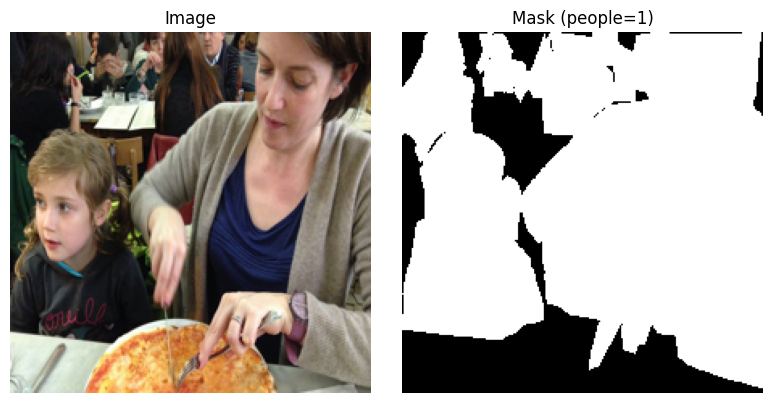

In [3]:
import matplotlib.pyplot as plt

# tensor -> numpy로 변환 (이미지는 [H,W,C]로)
img_np = img.permute(1, 2, 0).numpy()
# Normalize 되었다면 원래 색상 범위로 되돌리기
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)

mask_np = mask.numpy()

# 좌우 subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img_np)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(mask_np, cmap="gray")
axes[1].set_title("Mask (people=1)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [4]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

weights = DeepLabV3_ResNet101_Weights.DEFAULT
teacher = deeplabv3_resnet101(weights=weights)
teacher.eval()

trainable_params = sum(p.numel() for p in teacher.parameters() if p.requires_grad)
print("Teacher parameters:", trainable_params)


Teacher parameters: 60996202


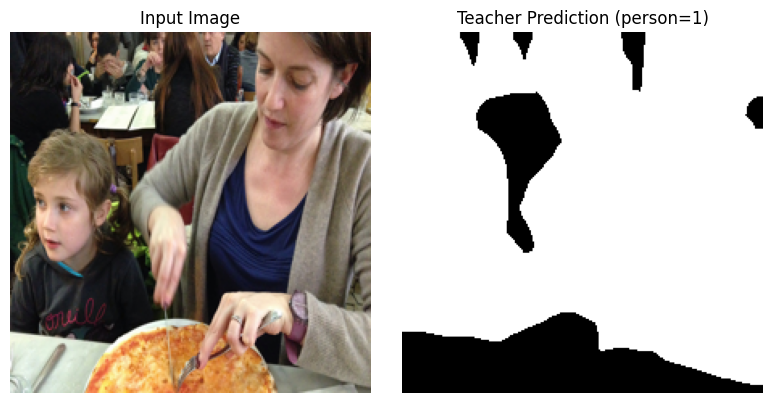

In [5]:
input_tensor = img.unsqueeze(0)

with torch.no_grad():
    output = teacher(input_tensor)['out']  # [1, num_classes, H, W]

# 4️⃣ 사람 클래스만 binary mask로 변환
# COCO pretrained DeepLabV3: person class = 15 (0~20)
person_class_id = 15
pred_mask = torch.argmax(output, dim=1).squeeze().cpu()
binary_mask = (pred_mask == person_class_id).long()  # 1=person, 0=others

# 5️⃣ 시각화
img_np = img.permute(1,2,0).numpy()
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(binary_mask.numpy(), cmap="gray")
plt.title("Teacher Prediction (person=1)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
from unet.unet_model import UNet

student = UNet(channel_depth=16, n_channels=3, n_classes=1)
''
trainable_params = sum(p.numel() for p in student.parameters() if p.requires_grad)
print("Student parameters:", trainable_params)

Student parameters: 839777


In [11]:
import numpy as np
from loss import loss_fn_kd
from metrics import dice_loss
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR


num_of_epochs = 5
summary_steps = 10

def fetch_teacher_outputs(teacher, train_loader):
    print('-------Fetch teacher outputs-------')
    teacher.eval().cuda()
    #list of tensors
    teacher_outputs = []
    with torch.no_grad():
        #trainloader gets bs images at a time. why does enumerate(tl) run for all images?
        for i, (img, gt) in enumerate(train_loader):
            print(i, 'i')
            '''img = img[0, :, :, :, :]
            gt = gt[0, :, :, :, :]'''
            if torch.cuda.is_available():
                img = img.cuda()
            img = Variable(img)

            output = teacher(img)
            teacher_outputs.append(output)
    return teacher_outputs

def train_student(student, teacher_outputs, optimizer, train_loader):
    print('-------Train student-------')
    #called once for each epoch
    student.train().cuda()

    summ = []
    for i, (img, gt) in enumerate(train_loader):
        teacher_output = teacher_outputs[i]
        if torch.cuda.is_available():
            img, gt = img.cuda(), gt.cuda()
            teacher_output = teacher_output.cuda()

        img, gt = Variable(img), Variable(gt)
        teacher_output =  Variable(teacher_output)

        output = student(img)

        #TODO: loss is wrong
        loss = loss_fn_kd(output, teacher_output, gt)    

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        if i % summary_steps == 0:
            #do i need to move it to CPU?
            
            metric = dice_loss(output, gt)
            summary = {'metric' : metric.item(), 'loss' : loss.item()}
            summ.append(summary)
    
    #print('Average loss over this epoch: ' + np.mean(loss_avg))
    mean_dice_coeff =  np.mean([x['metric'] for x in summ])
    mean_loss = np.mean([x['loss'] for x in summ])
    print('- Train metrics:\n' + '\tMetric:{}\n\tLoss:{}'.format(mean_dice_coeff, mean_loss))
    #print accuracy and loss

def evaluate_kd(student, val_loader):
    print('-------Evaluate student-------')
    student.eval().cuda()

    #criterion = torch.nn.BCEWithLogitsLoss()
    loss_summ = []
    with torch.no_grad():
        for i, (img, gt) in enumerate(val_loader):
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            img, gt = Variable(img), Variable(gt)

            output = student(img)
            output = output.clamp(min = 0, max = 1)
            loss = dice_loss(output, gt)

            loss_summ.append(loss.item())

    mean_loss = np.mean(loss_summ)
    print('- Eval metrics:\n\tAverage Dice loss:{}'.format(mean_loss))
    return mean_loss

min_loss = 100


optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size = 100, gamma = 0.2)


#2 tensors -> img_list and gt_list. for batch_size = 1 --> img: (1, 3, 320, 320); gt: (1, 1, 320, 320)
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 1
)
teacher_outputs = fetch_teacher_outputs(teacher, train_loader)
print(len(teacher_outputs))
for epoch in range(num_of_epochs):
    #train the student
    print(' --- student training: epoch {}'.format(epoch+1))
    train_student(student, teacher_outputs, optimizer, train_loader)



-------Fetch teacher outputs-------


AssertionError: Torch not compiled with CUDA enabled